Traditional transformer model


In [ ]:
!pip install torch torchvision torchaudio transformers sentence-transformers scikit-learn pandas numpy


Loading SBERT model (this may take a moment)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SBERT embedding shape (train): (4673, 384)

[Before oversampling] class counts:
Class 0: 679
Class 1: 2537
Class 2: 1457

[After oversampling] class counts:
Class 0: 2537
Class 1: 2537
Class 2: 2537
Epoch   1  Loss=1.6969  Train Acc=33.85%
Epoch  20  Loss=0.8880  Train Acc=60.45%
Epoch  40  Loss=0.7978  Train Acc=64.43%
Epoch  60  Loss=0.7655  Train Acc=66.65%
Epoch  80  Loss=0.7499  Train Acc=67.65%
Epoch 100  Loss=0.7403  Train Acc=67.93%

Total Training Time: 113.80 seconds


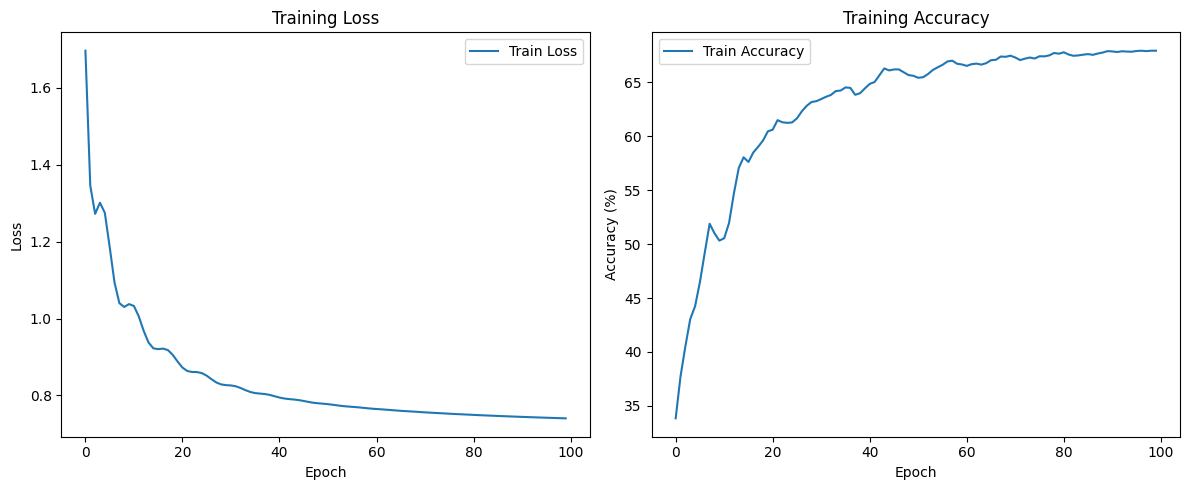


=== Final Test Accuracy: 60.65% ===
Test Inference Time: 0.0272 seconds


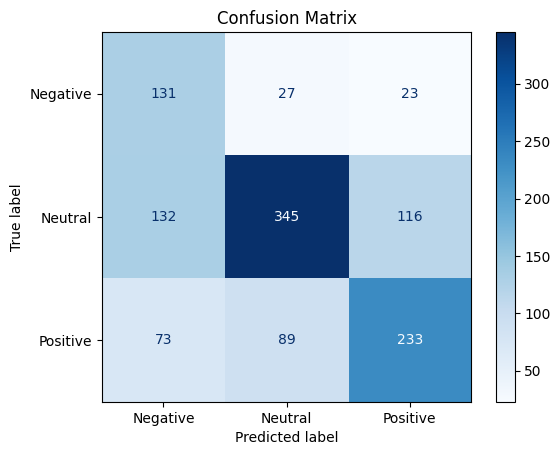


Classification Report:

              precision    recall  f1-score   support

    Negative       0.39      0.72      0.51       181
     Neutral       0.75      0.58      0.65       593
    Positive       0.63      0.59      0.61       395

    accuracy                           0.61      1169
   macro avg       0.59      0.63      0.59      1169
weighted avg       0.65      0.61      0.62      1169



In [ ]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def balance_classes(X, y, seed=42):
    np.random.seed(seed)
    unique, counts = np.unique(y, return_counts=True)
    max_count = np.max(counts)
    new_X, new_y = [], []
    for cls in unique:
        cls_idx = np.where(y == cls)[0]
        cls_samples = X[cls_idx]
        cls_labels  = y[cls_idx]
        if len(cls_samples) == 0:
            continue
        reps = max_count // len(cls_samples)
        rem  = max_count % len(cls_samples)
        if reps > 0:
            new_X.append(np.tile(cls_samples, (reps,1)))
            new_y.append(np.tile(cls_labels, reps))
        if rem > 0:
            choice = np.random.choice(len(cls_samples), rem, replace=True)
            new_X.append(cls_samples[choice])
            new_y.append(cls_labels[choice])
    X_bal = np.vstack(new_X)
    y_bal = np.hstack(new_y)
    perm = np.random.permutation(len(y_bal))
    return X_bal[perm], y_bal[perm]

class TransformerClassifierTorch(nn.Module):
    def __init__(self, input_dim, n_classes, d_model=128, seed=1, device=torch.device("cpu")):
        super().__init__()
        torch.manual_seed(seed)
        self.device = device
        self.d_model = d_model
        self.W_proj = nn.Linear(input_dim, d_model, bias=False)
        self.W_Q    = nn.Linear(d_model, d_model, bias=False)
        self.W_K    = nn.Linear(d_model, d_model, bias=False)
        self.W_V    = nn.Linear(d_model, d_model, bias=False)
        self.W_ff = nn.Linear(d_model, d_model, bias=True)
        self.W_out = nn.Linear(d_model, n_classes, bias=True)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.normal_(p, mean=0.0, std=0.1)
            else:
                nn.init.zeros_(p)
        for name, param in self.named_parameters():
            if "W_out" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        self.to(device)

    def forward(self, X):
        X_emb = self.W_proj(X)
        Q = self.W_Q(X_emb)
        K = self.W_K(X_emb)
        V = self.W_V(X_emb)
        scores = torch.matmul(Q, K.transpose(0,1)) / np.sqrt(self.d_model)
        attn = F.softmax(scores, dim=1)
        attn_out = torch.matmul(attn, V)
        X_res = X_emb + attn_out
        mean = X_res.mean(dim=1, keepdim=True)
        std  = X_res.std(dim=1, keepdim=True) + 1e-6
        X_norm = (X_res - mean) / std
        FF = self.W_ff(X_norm)
        FF = F.relu(FF)
        X_ff = X_norm + FF
        logits = self.W_out(X_ff)
        return logits, X_ff

def main():
    csv_path = r"/content/fin_data_1.csv"
    device = torch.device("cpu")
    np.random.seed(42)
    torch.manual_seed(42)

    df = pd.read_csv(csv_path)
    sentences = [clean_text(s) for s in df["Sentence"].astype(str).tolist()]
    label_map = {"positive":2,"pos":2,"1":2,"neutral":1,"neu":1,"2":1,"negative":0,"neg":0,"0":0}
    labels = df["Sentiment"].astype(str).str.lower().map(label_map)
    labels = labels.fillna(1).astype(int).to_numpy()

    idx = np.arange(len(sentences))
    np.random.shuffle(idx)
    split = int(0.8 * len(sentences))
    train_idx, test_idx = idx[:split], idx[split:]
    train_sent = [sentences[i] for i in train_idx]
    test_sent  = [sentences[i] for i in test_idx]
    train_lab  = labels[train_idx]
    test_lab   = labels[test_idx]

    print("Loading SBERT model (this may take a moment)...")
    sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

    X_train_cpu = sbert_model.encode(train_sent, convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    X_test_cpu  = sbert_model.encode(test_sent,  convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)

    print("SBERT embedding shape (train):", X_train_cpu.shape)

    print("\n[Before oversampling] class counts:")
    unique, counts = np.unique(train_lab, return_counts=True)
    for u,c in zip(unique,counts):
        print(f"Class {u}: {c}")

    X_train_bal, y_train_bal = balance_classes(X_train_cpu, train_lab)

    print("\n[After oversampling] class counts:")
    unique, counts = np.unique(y_train_bal, return_counts=True)
    for u,c in zip(unique,counts):
        print(f"Class {u}: {c}")

    X_train = torch.from_numpy(X_train_bal).to(device)
    y_train = torch.from_numpy(y_train_bal).long().to(device)
    X_test  = torch.from_numpy(X_test_cpu).to(device)
    y_test  = torch.from_numpy(test_lab).long().to(device)

    model = TransformerClassifierTorch(input_dim=X_train.shape[1], n_classes=3, d_model=128, seed=123, device=device)
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
    loss_fn = nn.CrossEntropyLoss()

    epochs = 100
    train_losses = []
    train_accs = []

    start_time = time.time()

    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        logits, X_ff = model(X_train)
        loss = loss_fn(logits, y_train)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            preds = logits.argmax(dim=1)
            acc = (preds == y_train).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)
        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d}  Loss={loss.item():.4f}  Train Acc={acc*100:.2f}%")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"\nTotal Training Time: {training_time:.2f} seconds")

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.array(train_accs)*100, label="Train Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Training Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.eval()
    with torch.no_grad():
        test_start = time.time()
        logits_test, _ = model(X_test)
        y_pred = torch.argmax(logits_test, dim=1).cpu().numpy()
        test_end = time.time()
        test_acc = (y_pred == y_test.cpu().numpy()).mean()

    print(f"\n=== Final Test Accuracy: {test_acc*100:.2f}% ===")
    print(f"Test Inference Time: {test_end - test_start:.4f} seconds")

    cm = confusion_matrix(y_test.cpu().numpy(), y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative","Neutral","Positive"])
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_test.cpu().numpy(), y_pred, target_names=["Negative","Neutral","Positive"]))

if __name__ == "__main__":
    main()

Quantum ml model

In [ ]:
pip install pennylane scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 23.0 MB/s eta 0:00:00


Quantum svc model

In [ ]:
pip install pennylane scikit-learn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 499.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 43.2 MB/s eta 0:00:00


In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn sentence-transformers pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 723.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9

Generating Sentence-BERT Embeddings...


Batches:   0%|          | 0/152 [00:00<?, ?it/s]

Reduced feature dimensions: 8
Before SMOTE: Counter({np.int64(1): 2303, np.int64(2): 1090, np.int64(0): 483})
After SMOTE: Counter({np.int64(2): 2303, np.int64(1): 2303, np.int64(0): 2303})
Quantum Circuit (Sample):
0: ──H──RY(-11.22)──RY(-10.49)†──H†─┤ ╭Probs
1: ──H──RY(2.69)────RY(9.33)†────H†─┤ ├Probs
2: ──H──RY(19.93)───RY(-0.29)†───H†─┤ ├Probs
3: ──H──RY(-3.92)───RY(1.37)†────H†─┤ ├Probs
4: ──H──RY(-11.27)──RY(-10.90)†──H†─┤ ├Probs
5: ──H──RY(8.01)────RY(-4.91)†───H†─┤ ├Probs
6: ──H──RY(-8.60)───RY(-13.97)†──H†─┤ ├Probs
7: ──H──RY(4.75)────RY(-5.17)†───H†─┤ ╰Probs


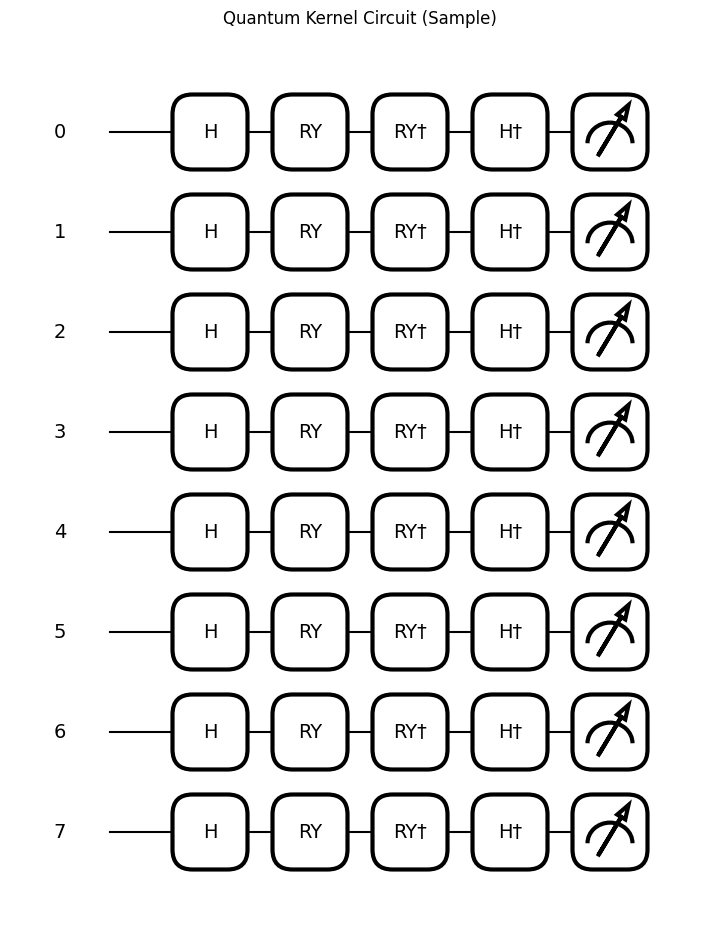

Computing Kernel Matrices...
Done in 67.87s
Best C: 0.1
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         2
     neutral       0.70      1.00      0.82        14
    positive       0.00      0.00      0.00         4

    accuracy                           0.70        20
   macro avg       0.23      0.33      0.27        20
weighted avg       0.49      0.70      0.58        20

Accuracy: 0.7
Macro F1 Score: 0.2745098039215686


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


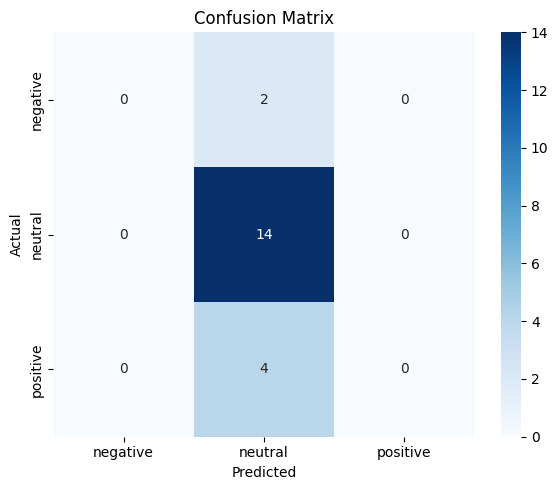

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import pennylane as qml
from pennylane import numpy as pnp
df = pd.read_csv("/content/all-data.csv", names=["Sentiment", "News_Headline"], encoding="ISO-8859-1")
df.dropna(inplace=True)
le = LabelEncoder()
df["Sentiment_Label"] = le.fit_transform(df["Sentiment"])
y = df["Sentiment_Label"].values
print("Generating Sentence-BERT Embeddings...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X = embedder.encode(df["News_Headline"].tolist(), show_progress_bar=True)
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=8, random_state=42)
X_reduced = pca.fit_transform(X_scaled)
print("Reduced feature dimensions:", X_reduced.shape[1])
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, stratify=y, random_state=42
)
print("Before SMOTE:", Counter(y_train))
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_bal))
n_qubits = X_train_bal.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(np.pi * x[i], wires=i)

def kernel_circuit(x1, x2):
    @qml.qnode(dev)
    def circuit():
        feature_map(x1)
        qml.adjoint(feature_map)(x2)
        return qml.probs(wires=range(n_qubits))
    return circuit()
@qml.qnode(dev)
def visual_circuit():
    feature_map(pnp.array(X_train_bal[0]))
    qml.adjoint(feature_map)(pnp.array(X_train_bal[1]))
    return qml.probs(wires=range(n_qubits))

print("Quantum Circuit (Sample):")
print(qml.draw(visual_circuit)())
try:
    qml.draw_mpl(visual_circuit)()
    plt.title("Quantum Kernel Circuit (Sample)")
    plt.show()
except:
    print("Matplotlib visualization skipped.")
def compute_kernel_matrix(X1, X2):
    return np.array([
        [kernel_circuit(pnp.array(x1), pnp.array(x2))[0] for x2 in X2]
        for x1 in X1
    ])

N_train, N_test = 60, 20
X_train_q, y_train_q = X_train_bal[:N_train], y_train_bal[:N_train]
X_test_q, y_test_q = X_test[:N_test], y_test[:N_test]

print("Computing Kernel Matrices...")
start = time.time()
kernel_train = compute_kernel_matrix(X_train_q, X_train_q)
kernel_test = compute_kernel_matrix(X_test_q, X_train_q)
print(f"Done in {time.time() - start:.2f}s")

#  SVM + GRID SEARCH
svc = SVC(kernel='precomputed')
param_grid = {'C': [0.1, 1, 10, 50]}
grid = GridSearchCV(svc, param_grid, cv=3)
grid.fit(kernel_train, y_train_q)
best_model = grid.best_estimator_
y_pred = best_model.predict(kernel_test)

print("Best C:", grid.best_params_["C"])
print("Classification Report:")is
print(classification_report(y_test_q, y_pred, target_names=le.inverse_transform(sorted(set(y_test_q)))))
print("Accuracy:", accuracy_score(y_test_q, y_pred))
print("Macro F1 Score:", f1_score(y_test_q, y_pred, average='macro'))
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_q, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.inverse_transform(sorted(set(y_test_q))),
            yticklabels=le.inverse_transform(sorted(set(y_test_q))))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn sentence-transformers pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 87.2 MB/s eta 0:00:00


QSVM with different appoaches of encoding

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn sentence-transformers pennylane


1) Loading dataset...
Using 5843 examples. Class distribution: Counter({1: 5423, 2: 317, 0: 103})
2) Generating sentence embeddings...


Batches:   0%|          | 0/183 [00:00<?, ?it/s]

3) Scaling + PCA to 8 components...
Train class distribution before SMOTE: Counter({np.int64(1): 4338, np.int64(2): 254, np.int64(0): 82})
Train class distribution after SMOTE: Counter({np.int64(1): 4338, np.int64(2): 4338, np.int64(0): 4338})

Encoding: angle
  computing quantum states for first set (size 13014)...
  computing quantum states for second set (size 13014)...
  computing quantum states for first set (size 1169)...
  computing quantum states for second set (size 13014)...
Gram matrices computed in 1037.2s

Classification report (encoding=angle):
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        21
     Neutral       0.93      1.00      0.96      1085
    Positive       0.00      0.00      0.00        63

    accuracy                           0.93      1169
   macro avg       0.31      0.33      0.32      1169
weighted avg       0.86      0.93      0.89      1169

Accuracy: 0.9281437125748503
Macro F1: 0.3209109730848

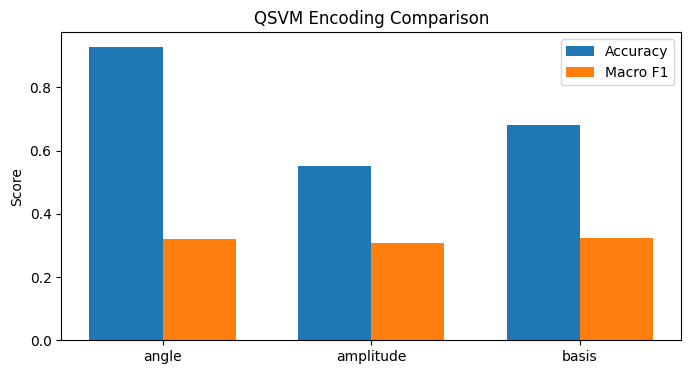

In [ ]:
#  QSVM Encoding Comparison



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time, math, warnings
warnings.filterwarnings("ignore")

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
import pennylane as qml
CSV_PATH = "/content/fin_data_1.csv"
CSV_COLNAMES = ["Sentiment", "News_Headline"]
PCA_DIM = 8
TEST_SIZE = 0.2
RANDOM_STATE = 42
SMOTE_RANDOM = 42
N_QUBITS = 4
N_LAYERS = 2
SVM_C = 1.0
BATCH_LIMIT = None

def map_sentiment(s):
    s = str(s).lower()
    if "pos" in s or "good" in s or "bullish" in s:
        return "Positive"
    elif "neg" in s or "bad" in s or "bearish" in s:
        return "Negative"
    else:
        return "Neutral"

print("1) Loading dataset...")
df = pd.read_csv(CSV_PATH, names=CSV_COLNAMES, encoding="ISO-8859-1")
df.dropna(inplace=True)
df["Sentiment_Grouped"] = df["Sentiment"].map(map_sentiment)
le = LabelEncoder()
df["Sentiment_Label"] = le.fit_transform(df["Sentiment_Grouped"])

if BATCH_LIMIT:
    df = df.sample(BATCH_LIMIT, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Using {len(df)} examples. Class distribution: {Counter(df['Sentiment_Label'])}")

# SENTENCE EMBEDDINGS
print("2) Generating sentence embeddings...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
X_raw = embedder.encode(df["News_Headline"].tolist(), show_progress_bar=True)
y_raw = df["Sentiment_Label"].values
print(f"3) Scaling + PCA to {PCA_DIM} components...")
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)
pca = PCA(n_components=PCA_DIM, random_state=RANDOM_STATE)
X_reduced = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_raw, test_size=TEST_SIZE, stratify=y_raw, random_state=RANDOM_STATE
)
print("Train class distribution before SMOTE:", Counter(y_train))
sm = SMOTE(random_state=SMOTE_RANDOM)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
print("Train class distribution after SMOTE:", Counter(y_train_bal))

X_train_np = np.array(X_train_bal, dtype=float)
y_train_np = np.array(y_train_bal, dtype=int)
X_test_np = np.array(X_test, dtype=float)
y_test_np = np.array(y_test, dtype=int)

def make_device(n_qubits):
    return qml.device("default.qubit", wires=n_qubits)

# Angle embedding
def state_from_inputs_angle(x, n_qubits, n_layers=N_LAYERS):
    for layer in range(n_layers):
        for i in range(n_qubits):
            qml.RY(x[i % len(x)] * np.pi, wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        for i in range(n_qubits):
            qml.RZ(0.1, wires=i)

# Amplitude embedding
def state_from_inputs_amplitude(x, n_qubits):
    vec_len = 2 ** n_qubits
    v = np.zeros(vec_len)
    copy_len = min(len(x), vec_len)
    v[:copy_len] = x[:copy_len]
    norm = np.linalg.norm(v)
    if norm == 0: v[0] = 1.0; norm = 1.0
    v /= norm
    qml.AmplitudeEmbedding(v, wires=range(n_qubits), normalize=True)

# Basis embedding
def state_from_inputs_basis(x, n_qubits, n_bins=4):
    q = np.floor(np.clip(x * n_bins, 0, n_bins-1)).astype(int)
    bits = [int(q[i % len(q)] % 2) for i in range(n_qubits)]
    for wire, b in enumerate(bits):
        if b == 1:
            qml.PauliX(wires=wire)

# Build QNode for state generation
def make_state_qnode(encoding, n_qubits):
    dev = make_device(n_qubits)
    @qml.qnode(dev, interface="autograd")
    def _state(x):
        if encoding == "angle":
            state_from_inputs_angle(x, n_qubits)
        elif encoding == "amplitude":
            state_from_inputs_amplitude(x, n_qubits)
        elif encoding == "basis":
            state_from_inputs_basis(x, n_qubits)
        else:
            raise ValueError("Unknown encoding")
        return qml.state()
    return _state

# Compute Gram (kernel) matrix
def compute_gram_matrix(X1, X2, state_qnode):
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    print(f"  computing quantum states for first set (size {n1})...")
    states1 = [state_qnode(x) for x in X1]
    print(f"  computing quantum states for second set (size {n2})...")
    states2 = [state_qnode(x) for x in X2]
    for i, s1 in enumerate(states1):
        for j, s2 in enumerate(states2):
            K[i, j] = np.abs(np.vdot(s1, s2))**2
    return K

#  QSVM COMPARISON
encodings = ["angle", "amplitude", "basis"]
results = []

for enc in encodings:
    print("\n====================================")
    print(f"Encoding: {enc}")
    start_enc = time.time()

    # Per-encoding scaling
    X_train_enc = X_train_np.copy()
    X_test_enc = X_test_np.copy()
    if enc == "angle":
        X_train_enc /= np.max(np.abs(X_train_enc), axis=0, keepdims=True)
        X_test_enc /= np.max(np.abs(X_test_enc), axis=0, keepdims=True)
    elif enc == "amplitude":
        X_train_enc /= np.linalg.norm(X_train_enc, axis=1, keepdims=True)
        X_test_enc /= np.linalg.norm(X_test_enc, axis=1, keepdims=True)
    elif enc == "basis":
        X_train_enc = MinMaxScaler().fit_transform(X_train_enc)
        X_test_enc = MinMaxScaler().fit_transform(X_test_enc)

    state_qnode = make_state_qnode(enc, N_QUBITS)

    # Compute Gram matrices
    t0 = time.time()
    K_train = compute_gram_matrix(X_train_enc, X_train_enc, state_qnode)
    K_test = compute_gram_matrix(X_test_enc, X_train_enc, state_qnode)
    t1 = time.time()
    print(f"Gram matrices computed in {t1-t0:.1f}s")

    # Train SVM
    svm = SVC(kernel="precomputed", C=SVM_C, random_state=RANDOM_STATE)
    svm.fit(K_train, y_train_np)
    y_pred = svm.predict(K_test)

    # Metrics
    acc = accuracy_score(y_test_np, y_pred)
    mac_f1 = f1_score(y_test_np, y_pred, average="macro")
    print(f"\nClassification report (encoding={enc}):")
    print(classification_report(y_test_np, y_pred, target_names=le.inverse_transform(sorted(set(y_test_np)))))
    print("Accuracy:", acc)
    print("Macro F1:", mac_f1)

    results.append({
        "encoding": enc, "accuracy": acc, "macro_f1": mac_f1,
        "K_train": K_train, "K_test": K_test, "y_pred": y_pred,
        "time": time.time()-start_enc
    })

print("\n==== Summary of Encodings ====")
import pandas as pd
summary = pd.DataFrame(results)[["encoding","accuracy","macro_f1","time"]]
print(summary)

# Plot comparison
plt.figure(figsize=(8,4))
x = np.arange(len(encodings))
width = 0.35
plt.bar(x - width/2, summary["accuracy"], width, label="Accuracy")
plt.bar(x + width/2, summary["macro_f1"], width, label="Macro F1")
plt.xticks(x, encodings)
plt.ylabel("Score")
plt.title("QSVM Encoding Comparison")
plt.legend()
plt.show()
